# 0.0 Imports

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
# import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import datetime
import requests

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ): # verbose serve para se queremos que printe cada interaçao da funçao do kfold 
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] ) # np.round faz mesma coisa do .2f em c e aqui em python

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y )
    cm = cm.values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) # rmse mede o erro 

## 0.2.Loading data

In [4]:
df_sales_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [14]:
df_test = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/test.csv' )

# 1.0 Data description


In [5]:
def jupyter_settings():    
    sns.set()
jupyter_settings()

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_new = [ 'store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','promo_interval' ]

# renaming
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print( 'number of Rows: {}'.format( df1.shape[0] ) )
print( 'number of Rows: {}'.format( df1.shape[1] ) )


number of Rows: 1017209
number of Rows: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: (df1['competition_distance'].max())*10 if math.isnan( x ) else x )


# competition_open_since_month
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )



# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

KeyboardInterrupt: 

In [ ]:

df1.isna().sum()

In [ ]:
df1['competition_distance'].max()

In [ ]:
df1.sample(5).T

## 1.6 Change Types

In [ ]:
print( df1.dtypes )


In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


## 1.7 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency -  mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skev, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis ) ).T 

# concatenate
dfDesc = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d4 ] ).T.reset_index()

dfDesc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
print(dfDesc)

             attributes   min       max     range         mean  median  \
0                 store   1.0    1115.0    1114.0   558.429727   558.0   
1           day_of_week   1.0       7.0       6.0     3.998341     4.0   
2                 sales   0.0   41551.0   41551.0  5773.818972  5744.0   
3             customers   0.0    7388.0    7388.0   633.145946   609.0   
4                  open   0.0       1.0       1.0     0.830107     1.0   
5                 promo   0.0       1.0       1.0     0.381515     0.0   
6        school_holiday   0.0       1.0       1.0     0.178647     0.0   
7  competition_distance  20.0  758600.0  758580.0  7386.296140  2330.0   
8                promo2   0.0       1.0       1.0     0.500564     1.0   
9              is_promo   0.0       1.0       1.0     0.155231     0.0   

            std       skew  kurtosis  
0    321.908493  -0.000955    1114.0  
1      1.997390   0.001593       6.0  
2   3849.924283   0.641460   41551.0  
3    464.411506   1.598650   

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

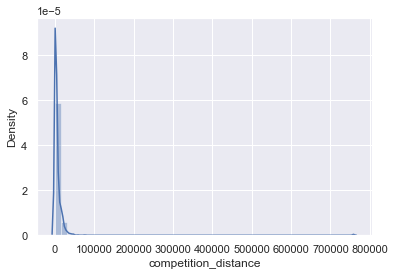

In [20]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='store_type', ylabel='sales'>

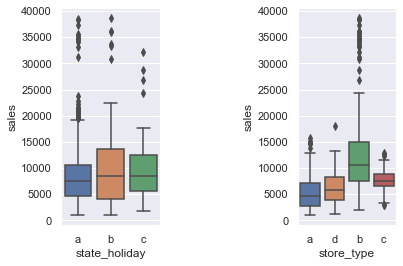

In [22]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )] 

plt.subplot( 1,3,1 )
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot( 1,3,3 )
sns.boxplot( x='store_type' , y='sales' , data=aux1 )


# 2.0 Feature Engineering

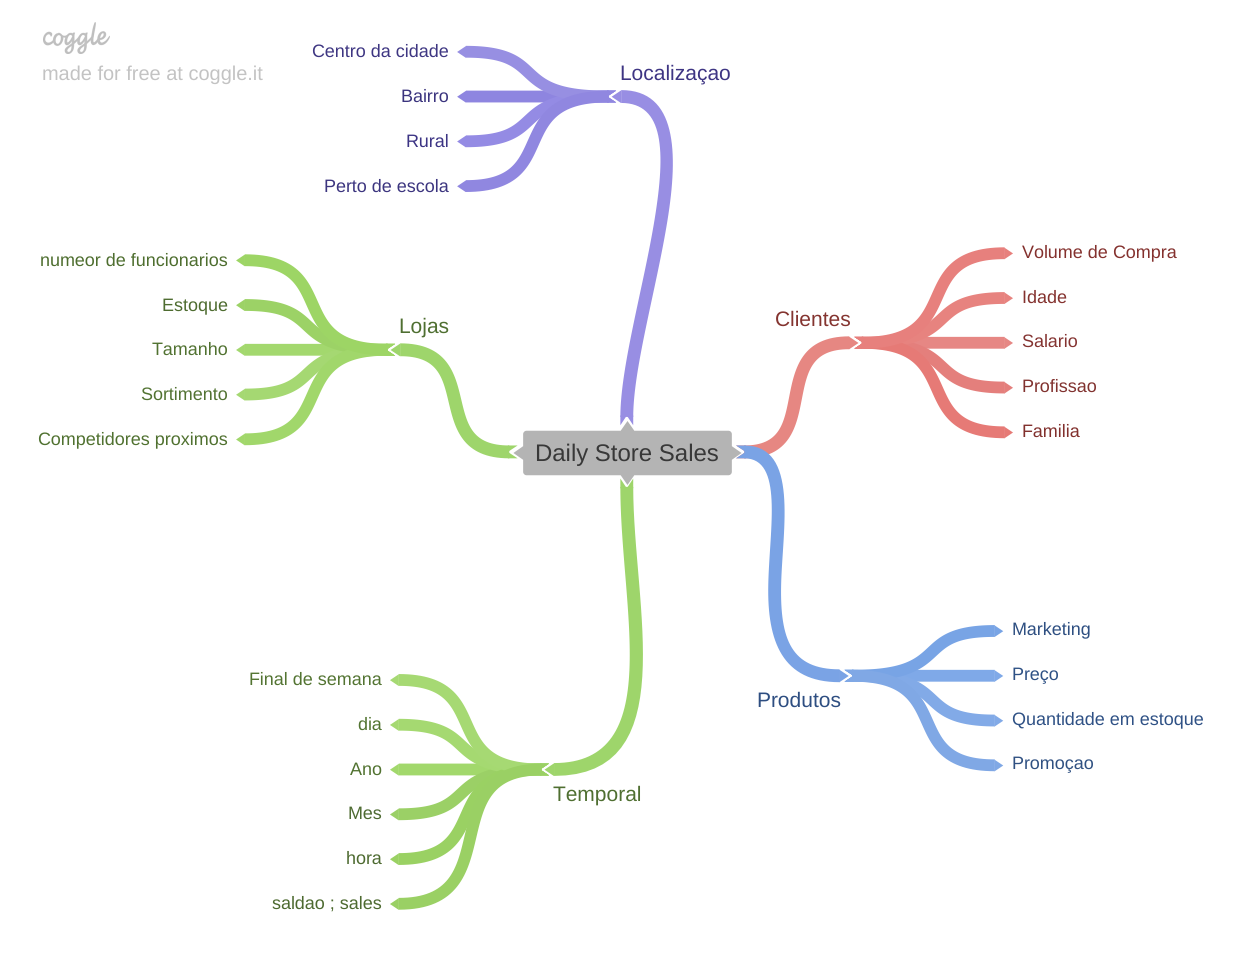

In [23]:
df2 = df1.copy()
Image( 'img/MindMapHypothesis.png' )

## 2.1 Mind map Hypothesis


### 2.1.1 Store Assumptions


** 1. ** Stores with higher number of seller employees sell more. (I don't have number of employees in this dataset)

** 2. ** Stores with higher stock capacity sell more. (I don't have stock info)

** 3. ** Larger sized stores sell more. 

** 4. ** Stores with larger company assortments sell more.

** 5. ** Stores with more practice competitors sell less.

** 6. ** Stores with competitors for the longest school years sell more.


### 2.1.2 Product Assumptions

**1.** Stores that invest more in Marketing should sell more. (I have no marketing expenses (budget))

**2.** Stores with greater product exposure should sell more. (I don't have a quantity of products with exposure)

**3.** Stores with products with a lower price should sell more. (I don't have product prices)

**5.** Stores with more aggressive promotions (bigger discounts), should sell more. (We don't have promotion categories)

**6.** Stores with promotions active for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.


### 2.1.3 Time Assumptions


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2 Final Assumptions

#### Final Store List

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.


#### Final product List

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.


#### Final time List

**8.** Stores open during the Christmas holiday should sell more.

**9.** Stores should sell more over the years.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more after the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

## 2.3 Feature Engineering

In [25]:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# # competition since
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# promo since
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )



# 3.0 Data Filtering

In [29]:
df3 = df2.copy()

## 3.1 Rows filtering

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns filtering

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# axis 0 => linhas
# axis 1 => colunas
df3 = df3.drop( cols_drop, axis=1 )


In [33]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis ( EDA )

In [34]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Respose Variable

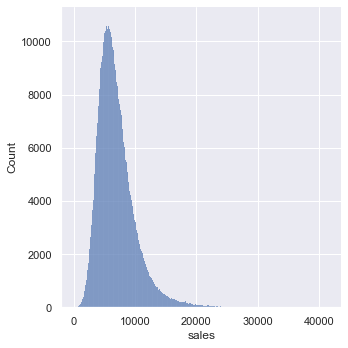

In [35]:
sns.displot( df4['sales'] )

### 4.1.2 Numerical Variable

<Figure size 3600x360 with 0 Axes>

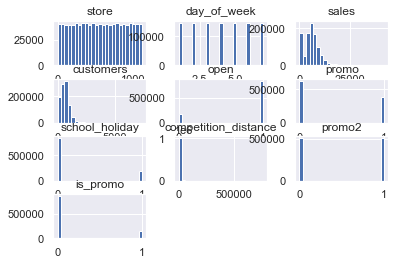

In [36]:
plt.figure( figsize=( 50, 5 ) )
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

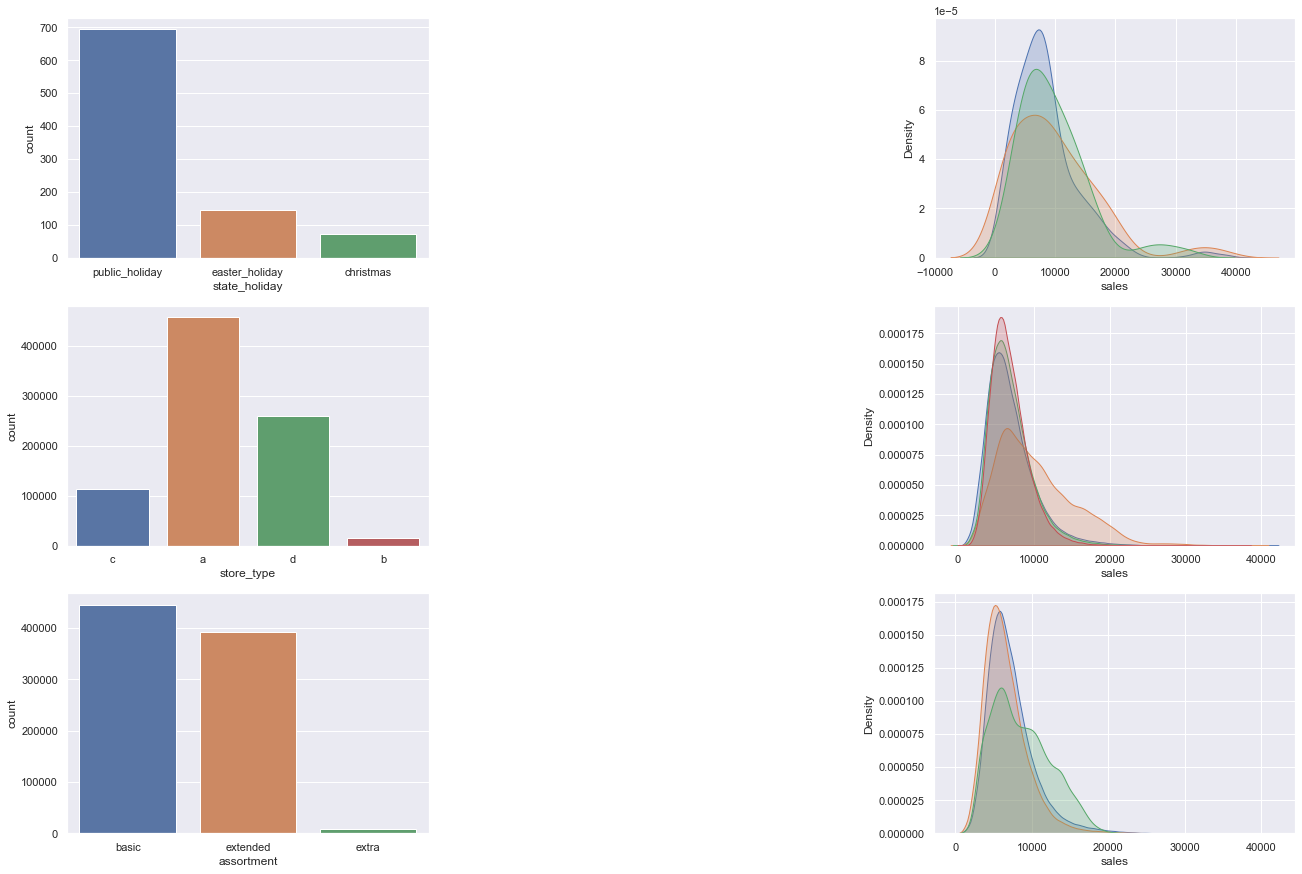

In [38]:
plt.figure( figsize=( 22, 15 ) )
# state_holiday
plt.subplot( 3, 3, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 3, 3 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 3, 4 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 3, 6 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 3, 7 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 3, 9 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Bivariate Analysis

### **H1.** Stores with larger assortments (product mix) should sell more.
**FALSE** Stores with MORE ASSISTANCE sell LESS.<p>
**Is it important for the model?** Yes, because even if the basic and the extended are similar, the extra has a peculiar behavior that it is worth training the model with it.

<AxesSubplot:xlabel='year_week'>

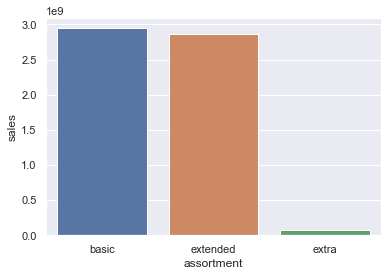

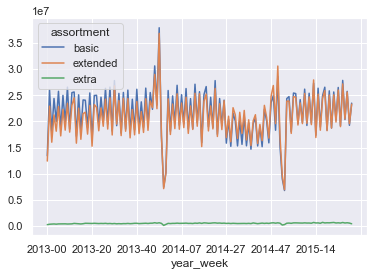

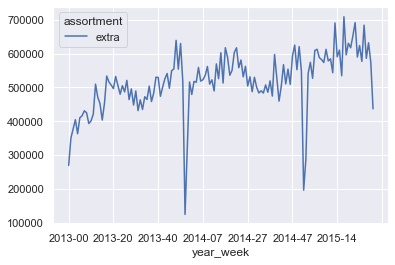

In [39]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.plot()

aux4 = aux2[ aux2['assortment'] == 'extra' ]
aux5 = aux4.pivot( index='year_week', columns='assortment', values='sales' )
aux5.plot()

In [40]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


### **H2.** Stores with closer competitors should sell less.(common sense)
**FALSE** Stores with CLOSER COMPETITORS sell MORE.<p>
**Is it important for the model?** It might be important for the model, but in a weaker way

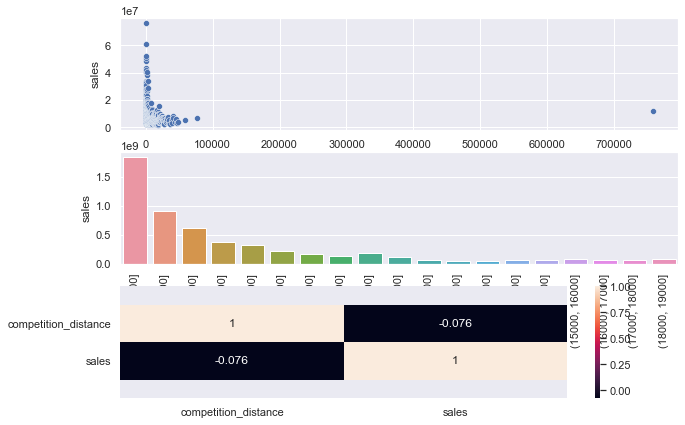

In [42]:
plt.figure( figsize=( 10, 7 ) )
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 3, 1, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 3, 1, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 3, 1, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );# ver a correlaçao das distancias e das vendas
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [43]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
516,12770.0,7317626,"(12000, 13000]"
18,200.0,23049560,"(0, 1000]"
263,3320.0,4253485,"(3000, 4000]"
426,7680.0,10870270,"(7000, 8000]"


### **H3.** Stores with longer-term competitors should sell more.
**False** Stores with longer-time competitors sell less, very counterintuitive

**Is it important for the model?** may be, but not so, weak pearson

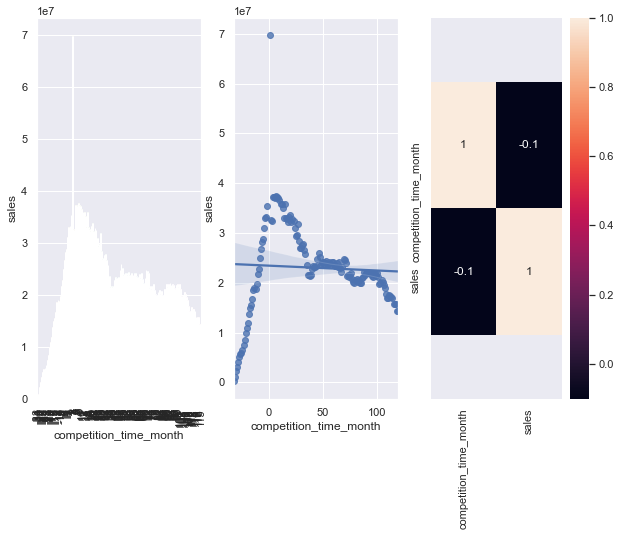

In [44]:
plt.figure( figsize=( 10, 7 ) )
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

In [45]:
df4.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H4 .Stores with larger assortments should sell more.
**False** because stores with promotions active for a long time sell less after a certain period of promotion

**Is it important for the model?** No, low pearson

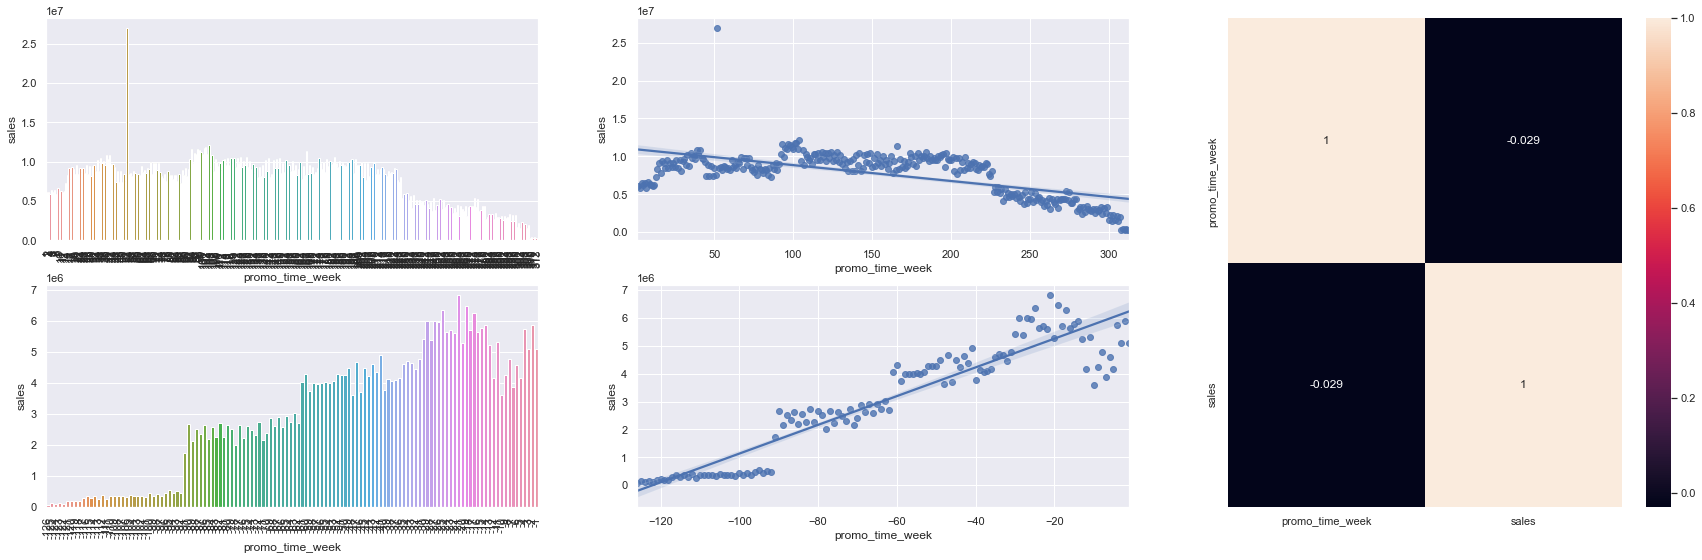

In [46]:
plt.figure( figsize=( 30, 9 ) )

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Stores with more promotion days should sell more</s>

In [47]:
# let's leave it for the second cycle of CRISP-DaS

### H7.Stores with more consecutive promotions should sell more
- This hypothesis is not so relevant for the model, as it is very little different from the traditional and extended to the extended one, and the strange behavior that could be analyzed by the model is very small so it shouldn't even influence, then we get an opinion from an algorithm

**False** Stores with more consecutive promotions sell less

**Is it important for the model?** Yes, there is a phenomenon that the traditional way falls out of nowhere, which can be important for the model to learn

In [48]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


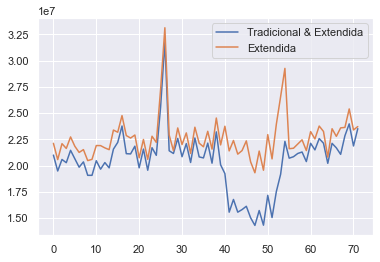

In [49]:

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### **H8.** Stores open during the Christmas holiday should sell more.
**False** Stores open during the Christmas holiday sell less

- It's already known, it's not an insight

**Is it important for the model?** Yes, because if it's a holiday it changes how the model has to predict

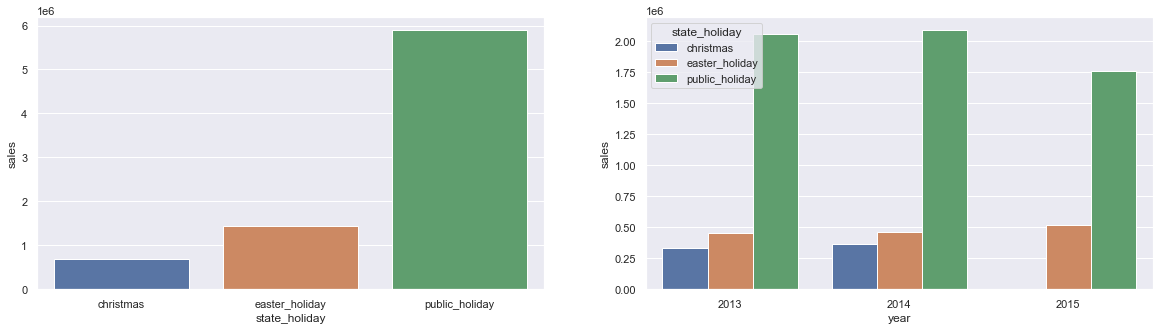

In [50]:
plt.figure( figsize=( 20, 5 ) )
plt.subplot( 1,2,1 )
aux = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1,2,2 )
aux2 = aux[['year','state_holiday', 'sales' ]].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Stores should sell more over the years.
**False** Stores sell less over the years

- It's not insight, because people should already know
- Always compare between closed periods, otherwise there will be a problem in your analysis, since you do not have all the data for that period

**Is it important for the model?** Yes, very high correlation

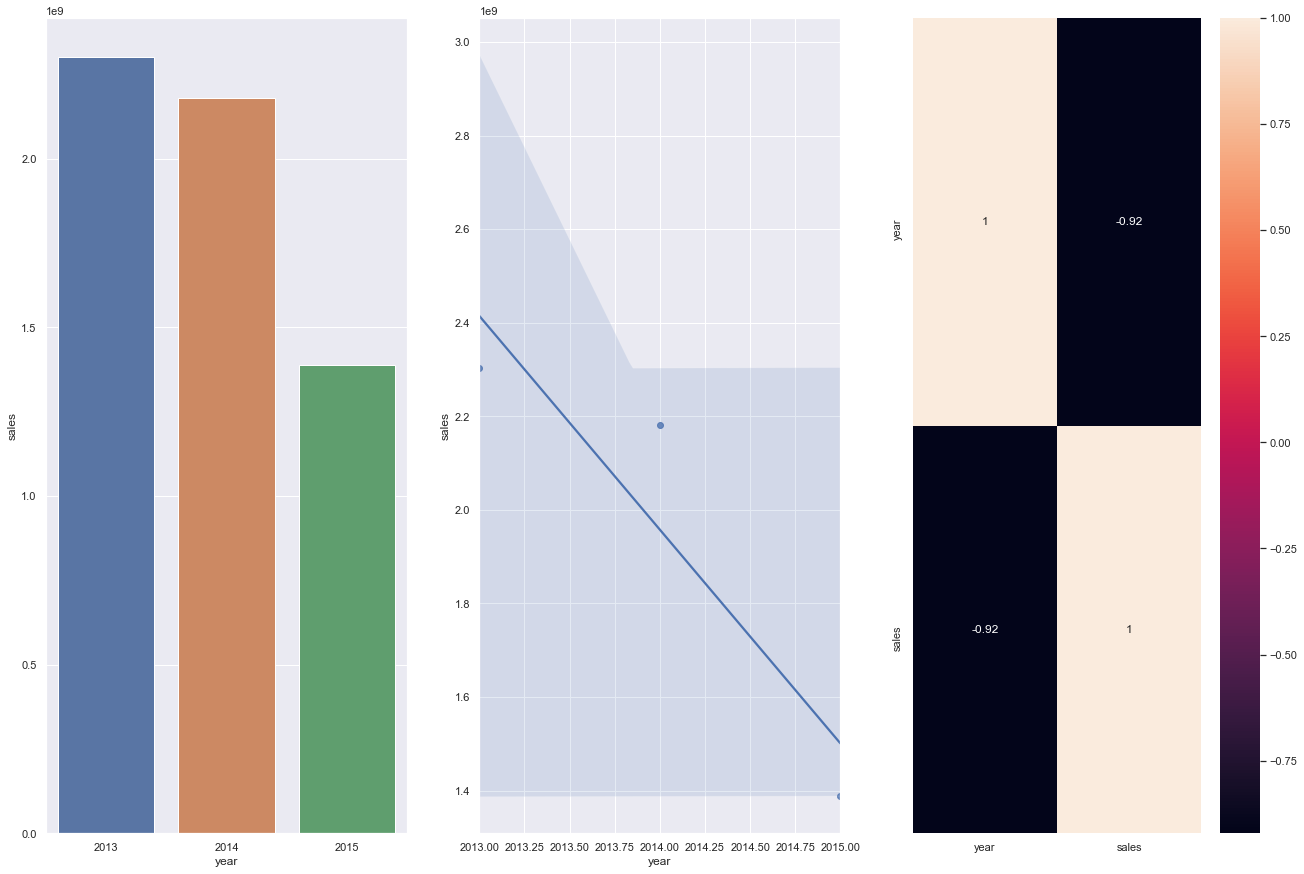

In [51]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Stores should sell more in the second half of the year.

- It's not an insight, people should already know that, it's neither counter-intuitive nor new information


**Is it important for the model?**Yes, high correlation

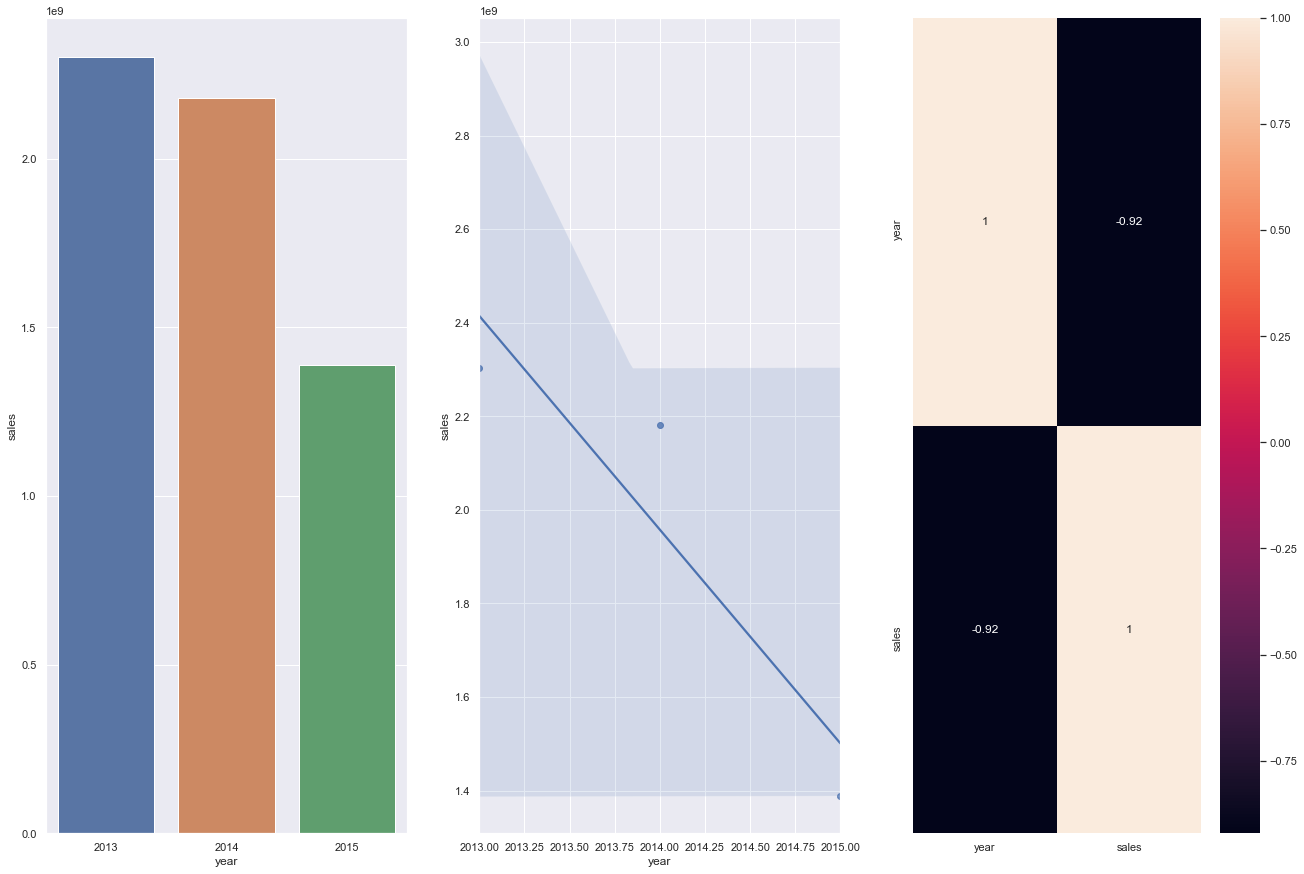

In [52]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Stores should sell more after the 10th of each month.
**True** Stores sell more after the 10th of each month

- It's not insight, because people follow it already

**Is it important for the model?** Yes, because it has a certain negative correlation (the larger one, the smaller the other)

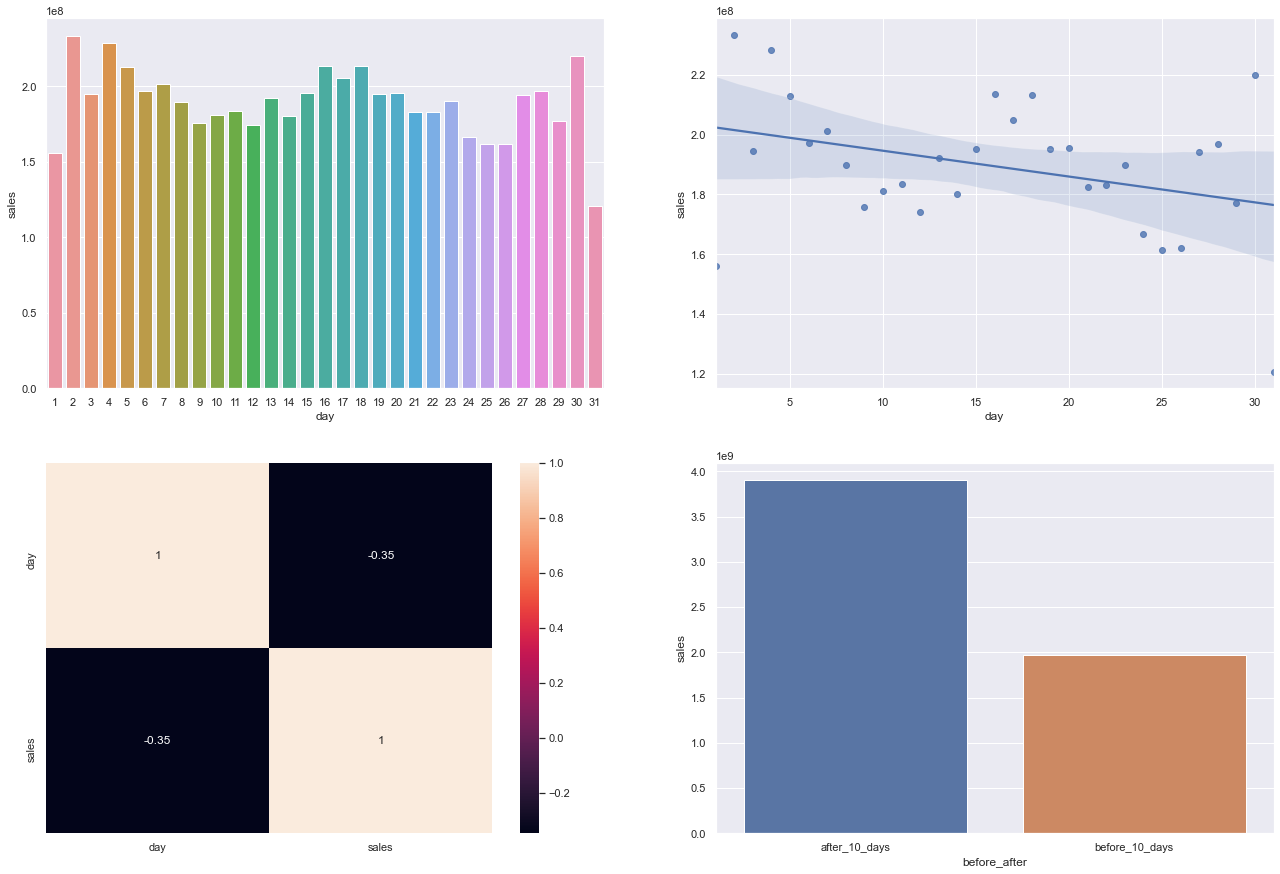

In [53]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2,2,1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x<=10 else 'after_10_days' )

plt.subplot( 2,2,4 )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );


### **H12.** Stores should sell less on weekends.
**True** Stores sell less on weekends

**Is it important for the model?** Yes, high correlation

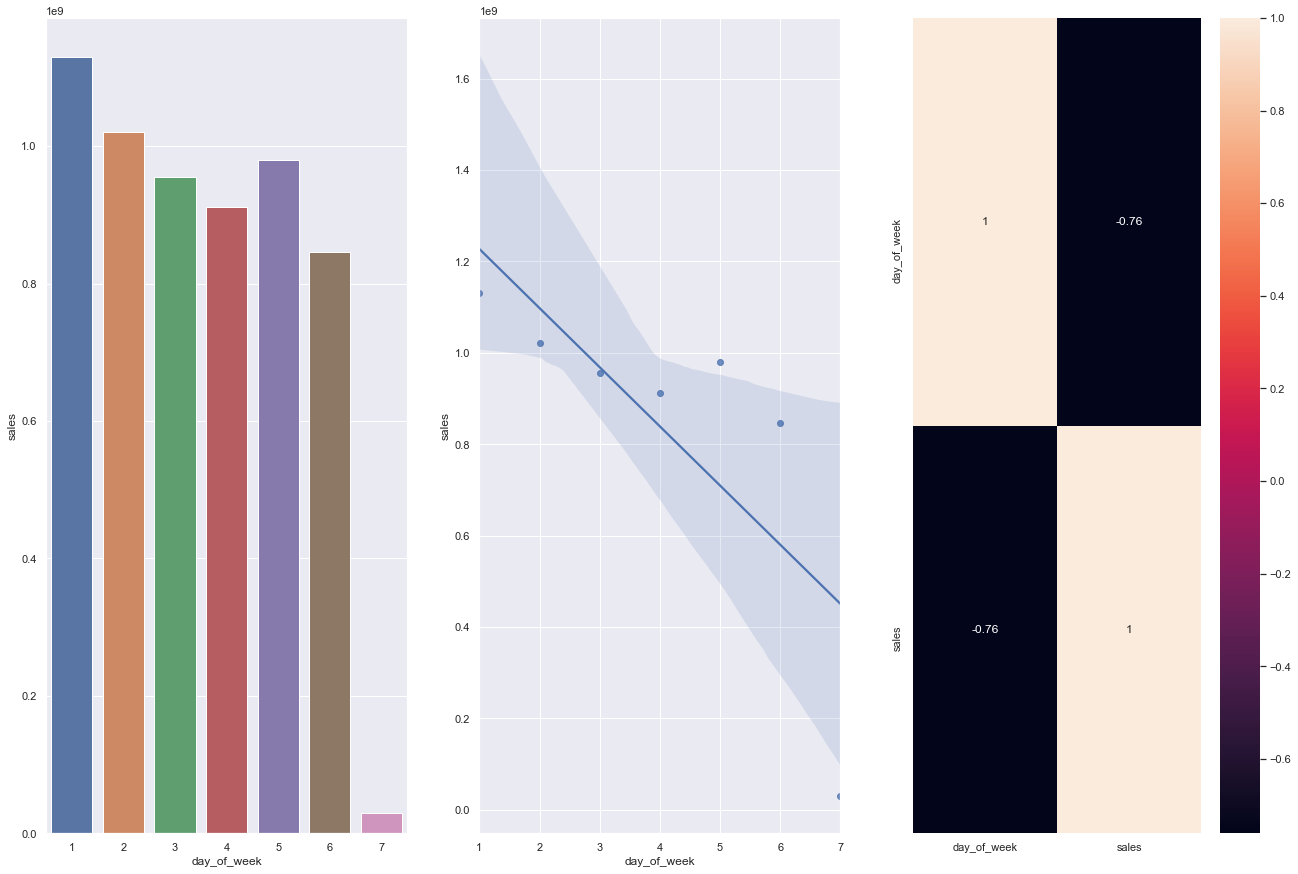

In [54]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Stores should sell less during school holidays.
**True** Stores sell less during school holidays, except July and August

- Noa should be insight, the business team should already know that

**Is it important for the model?** Yes, to model the algorithm you need to know if it's a school holiday, and what month it is

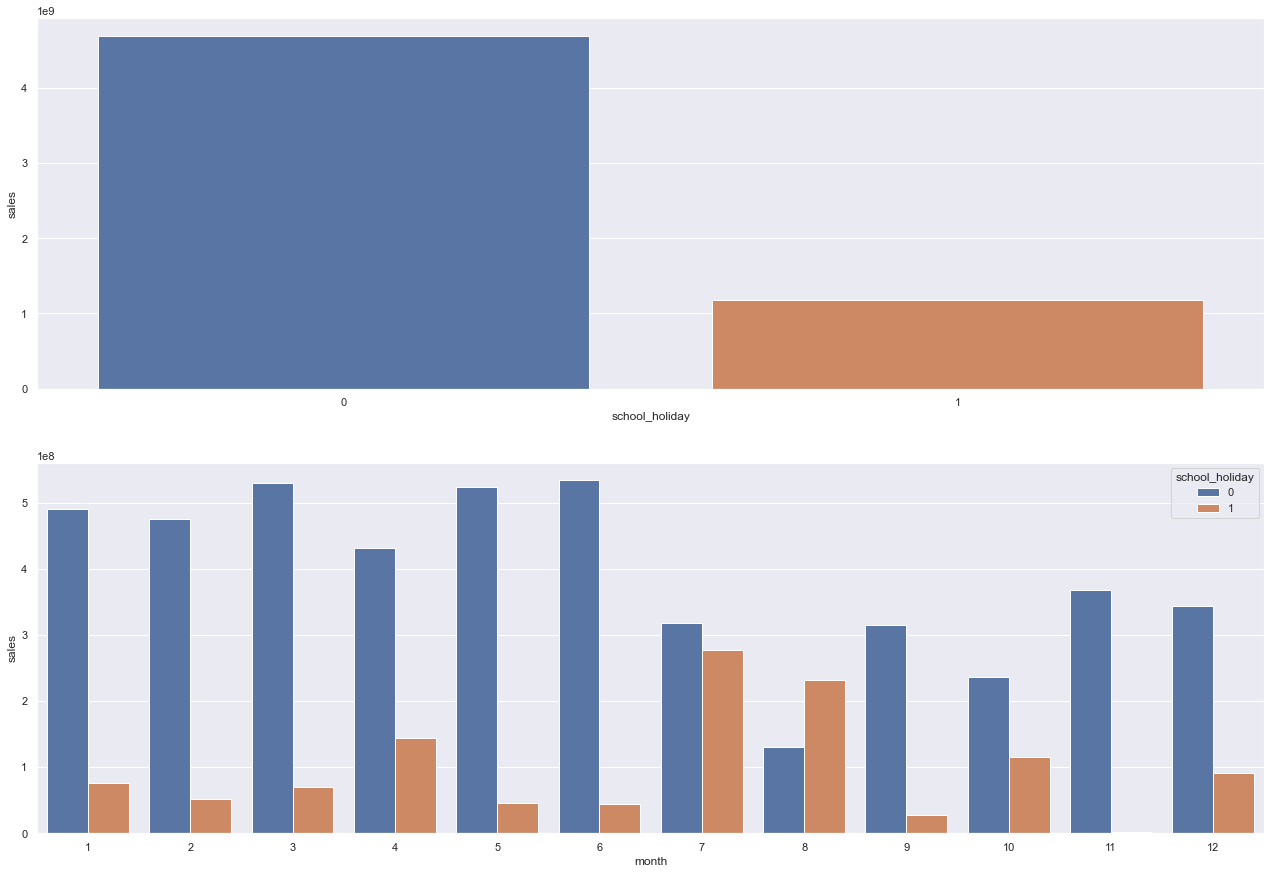

In [55]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2,1,1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month','school_holiday', 'sales']].groupby([ 'month','school_holiday' ]).sum().reset_index()

plt.subplot( 2,1,2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


## 4.2.1 Summary of hypotheses

In [56]:
# from tabulate import tabulate

In [57]:

# tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
#       ['H1', 'Falsa', 'Baixa'],  
#       ['H2', 'Falsa', 'Media'],  
#       ['H3', 'Falsa', 'Media'],
#       ['H4', 'Falsa', 'Baixa'],
#       ['H5', '-', '-'],
#       ['H7', 'Falsa', 'Baixa'],
#       ['H8', 'Falsa', 'Media'],
#       ['H9', 'Falsa', 'Alta'],
#       ['H10', 'Falsa', 'Alta'],
#       ['H11', 'Verdadeira', 'Alta'],
#       ['H12', 'Verdadeira', 'Alta'],
#       ['H13', 'Verdadeira', 'Baixa'],
#      ]  
# print( tabulate( tab, headers='firstrow' ) )


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

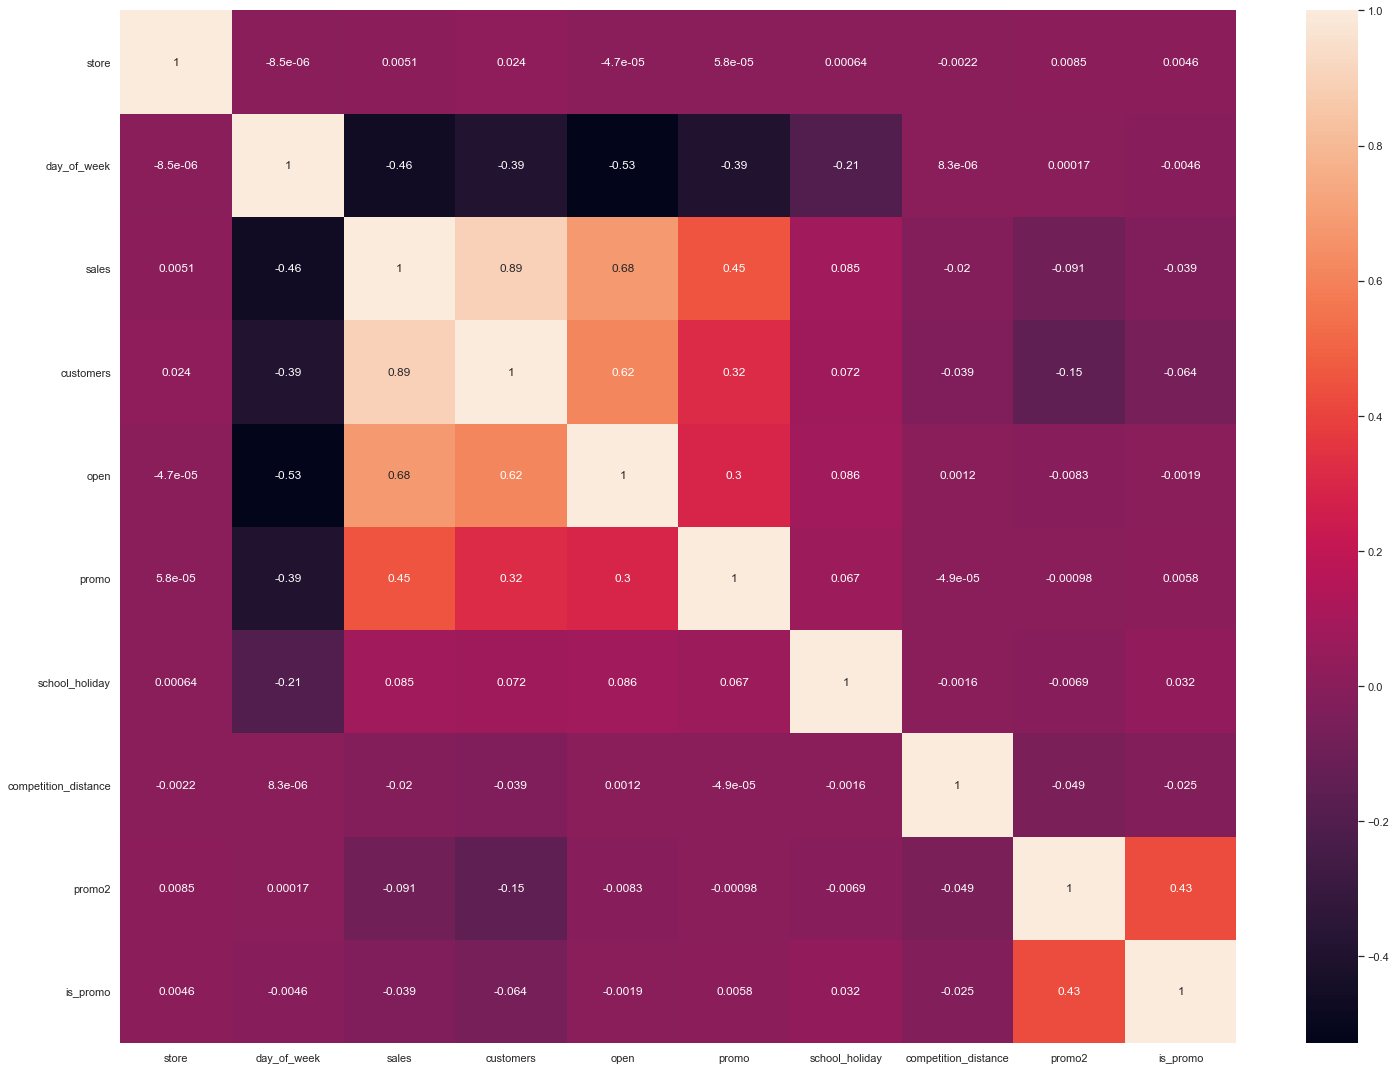

In [58]:
correlation = num_attributes.corr( method='pearson' )
plt.figure( figsize=( 25, 19 ) )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

In [59]:
a = df4.select_dtypes( include='object' )

In [60]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [61]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] )
cm = cm.values

In [62]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                   'store': [a4,a5,a6],
                   'assortment': [a7,a8,a9],    
                    })
d = d.set_index( d.columns )


In [63]:
d

,state_holiday,store,assortment
state_holiday,1.000002,0.071065,0.067546
store,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

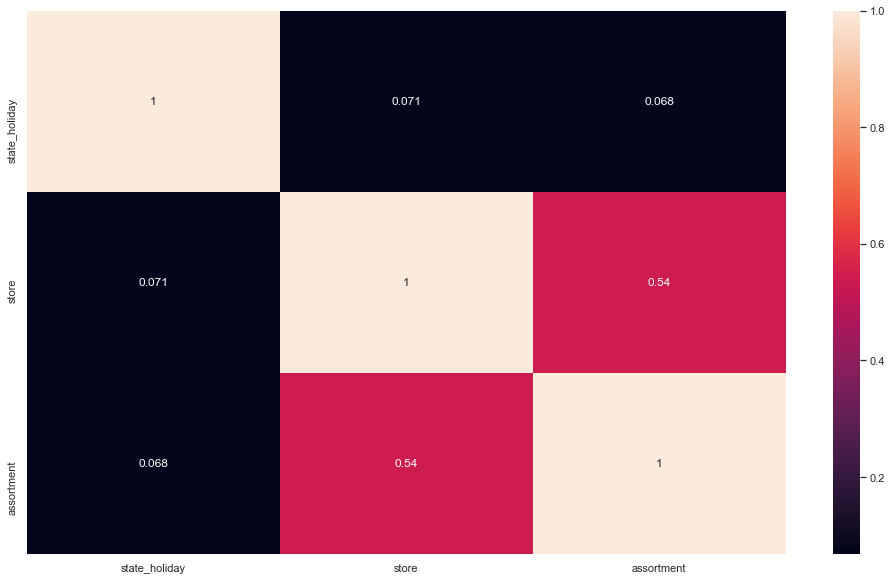

In [64]:
plt.figure( figsize=( 17, 10 ) )
sns.heatmap( d, annot=True )


# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

## 5.1 Standardization

In [66]:
# It is not necessary to do so, as there is no categorical variable
# has a distribution that looks normal by itself

## 5.2 Rescaling

In [67]:
a = df5.select_dtypes( include=['int64', 'float64','int32','UInt32'] )

<AxesSubplot:xlabel='competition_distance'>

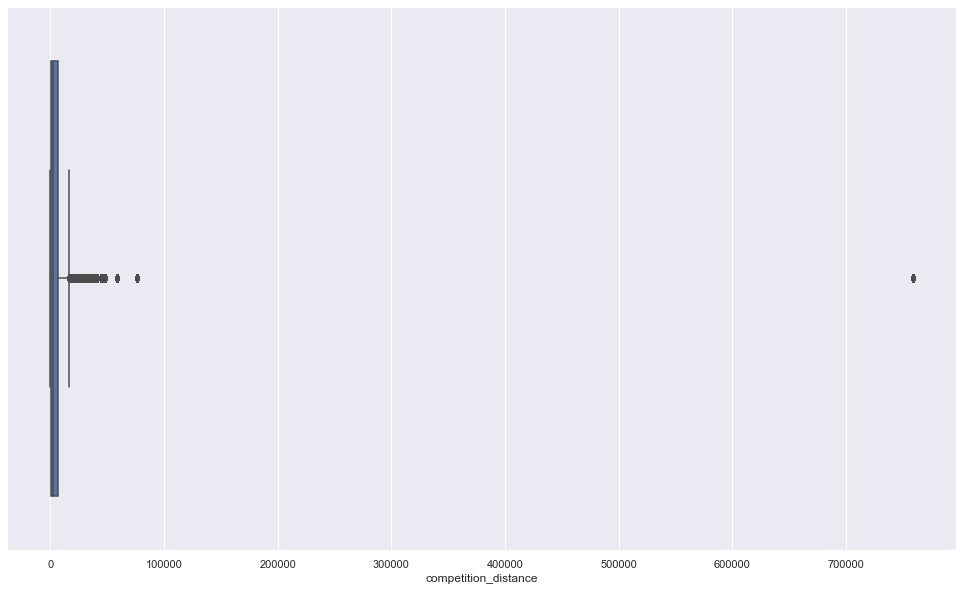

In [68]:
plt.figure( figsize=( 17, 10 ) )
sns.boxplot( df5['competition_distance'] )

In [69]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameters/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameters/year_scaler.pkl', 'wb') )

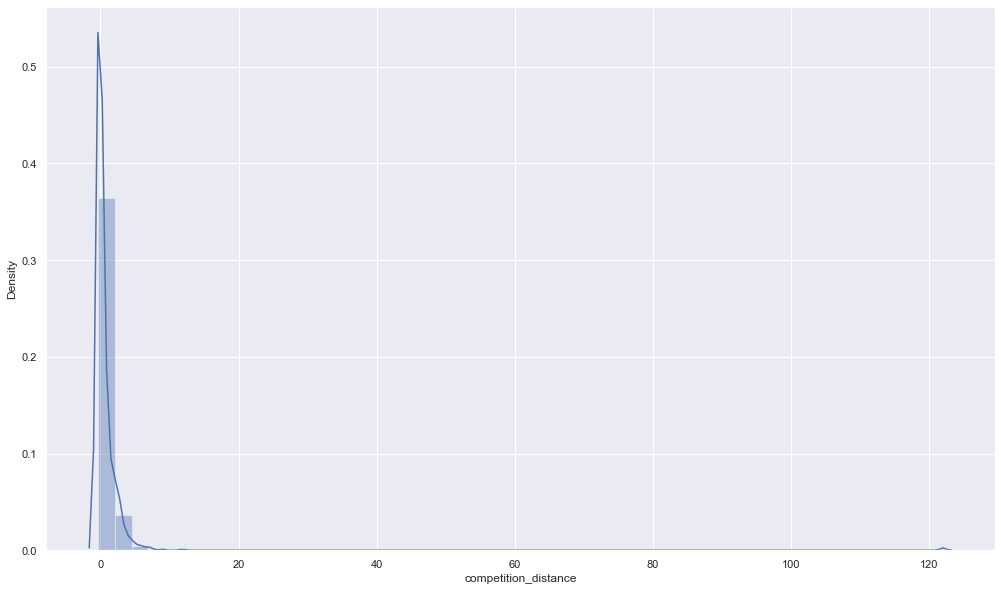

In [70]:
plt.figure( figsize=( 17, 10 ) )
sns.distplot( df5['competition_distance'] );

## 5.3 Transformation

### 5.3.1 Encoding

In [71]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [72]:
# state holiday
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/store_type_scaler.pkl', 'wb') )


df5['assortment'].drop_duplicates() 
# assortment
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] =  df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [73]:
df5['sales'] = np.log1p( df5['sales'] )

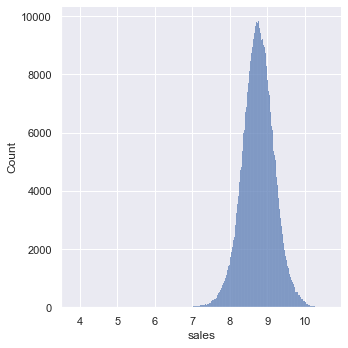

In [74]:
sns.displot( df5['sales'] )

### 5.3.3 Nature Transformation( cycle transformation )

In [75]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )                                                 
                                                    
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )                                                                    

# 6.0 Feature Selection


In [78]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [79]:
cols_drop = ['week_of_year','day','month', 'day_of_week','promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [80]:
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0]  - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [81]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19'] 
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [82]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values  
y_train_n = y_train.values.ravel() 

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 ) 

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n ) 

### 6.2.1 Best Features From Boruta 

In [83]:

cols_selected = boruta.support_.tolist() 

# best features 
x_train_fs = x_train.drop( ['date', 'sales'], axis=1 ) 
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list

# not selected boruta 
cols_not_selected_boruta = np.setdiff1d( x_train_fs.columns, cols_selected_boruta )


### 6.2.2 Manual feature selection

In [84]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 ML models 

In [85]:
x_train = X_train[ cols_selected_boruta ]  
x_test = X_test[ cols_selected_boruta ]

x_training  = X_train[ cols_selected_boruta_full ] 

## 7.1 Average Model

In [86]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'}  )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions'] 

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) 
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [87]:
# cross validation n faz sentido fazer pra esse modelo

## 7.2 Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit( x_train, y_train )


# prediction 
yhat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1863.879857,0.292198,2672.592495


### 7.2.1 Linear Regression Model Crossvalidation

In [89]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False ) # 5 kfols => 5 separaçaoes do nosso dado de treinamento, verbose=False => significa que nao queremos que ele fique printando as iteraçoes

In [90]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.64 +/- 295.12,0.3 +/- 0.02,2957.68 +/- 467.06


## 7.3 Linear Regression Regularized Model - Lasso


In [91]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )


# prediction 
yhat_lrr = lrr.predict( x_test )

# performance 
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.157813,0.28896,2745.550239


### 7.3.1 Linear Regression Regularized Model - Lasso Cross validation


In [92]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False ) 

In [93]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.26 +/- 341.08,0.29 +/- 0.01,3061.0 +/- 503.47


## 7.4 Random Forest Regressor

In [94]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction 
yhat_rf = rf.predict( x_test )

# performance 
rf_result = ml_error( 'Random forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

### 7.4.1 Random Forest Regressor CrossValidation

In [95]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

In [96]:
# "Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36"
# rf_result_cv
#  demora 11h pra executar o codigo de crossvalidation com random forest +/-
print ( "Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36" )

Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36


## 7.5 XGBoost Regressor

In [97]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              eta=0.01, 
                              n_estimators=100, 
                              n_jobs=-1, 
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9, 
                              ).fit( x_train, y_train ) 




# prediction 
yhat_xgb = model_xgb.predict( x_test )

# performance 
xgb_result = ml_error( 'XGB Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[06:06:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

## 7.5.1 XGBoost Regressor Crossvalidation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv
# XGBoost Regressor	1030.28 +/- 167.19	0.14 +/- 0.02	1478.26 +/- 229.79

## 7.6 Compare Model's Performance

### 7.6.1 Compare Model's Performance - Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

    # modelname            mae          mape        rmse
# 0	Random forest Regressor	679.598831	0.099913	1011.119437
# 0	Average Model	1354.800353	0.206400	1835.135542
# 0	Linear Regression	1863.879857	0.292198	2672.592495
# 0	Linear Regression - Lasso	1890.157813	0.288960	2745.550239
# 0	XGB Regressor	6683.606400	0.949503	7330.742181

### 7.6.2 Compare Model's Performance -  Real Performance

In [ ]:
modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

#   model-name           MAE CV               MAPE CV           RMSE CV
# 0	Linear Regression	2081.73 +/- 295.63	 0.3 +/- 0.02	 2952.52 +/- 468.37
# 0	Lasso	            2116.38 +/- 341.5	 0.29 +/- 0.01	 3057.75 +/- 504.26
# 0	Random Forest Regr	837.68 +/- 219.1	 0.12 +/- 0.02	 1256.08 +/- 320.36
# 0	XGBoost Regressor	1030.28 +/- 167.19	 0.14 +/- 0.02	 1478.26 +/- 229.79


# 8.0 Hyperparameter fine tuning

## 8.1 Random Search

In [ ]:
param = {
   'n_estimators': [15, 17, 25, 30, 35],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 10 

In [ ]:
# choose values for parameters randomly
hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
print( hp )
   
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

# performance
result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
final_result = pd.concat( [final_result, result] )
       
final_result

## 8.2 Final Model 

In [ ]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train ) # pois o ml_error so ve a performance do modelo, mas n o treina

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )  

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned



In [ ]:
pickle.dump( model_xgb_tuned, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/model_rossmann.pkl', 'wb') )

In [ ]:
#                         mae         mape        rmse
# 0	XGBoost Regressor	664.974996	0.097529	957.774225


In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

# 9.0 Translation and interpretation of the error

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business Performance

In [ ]:
# sum of predictions
df91= df9[['store','predictions']].groupby( 'store' ).sum().reset_index()  

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index(). rename( colums={0:'MAE'} )


df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( colums={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 =  pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordering columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head() 

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' ) # plotar uma linha no 1 atraves do eixo x

plt.subplot( 2, 2, 3 ) 
sns.distplot( df9['error'] ) # nossos erros tem um distribuiçao perto da gaussiana, a normal, isso é mt bom

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )


# 10.0 Deploy 

## 10.1 Rossmann Class

In [99]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameters/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameters/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
        

## 10.2 API Handler

In [125]:
from flask import Flask, request, Response # flask é o modulo e Flask é a classe
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann

# loading model 
model = pickle.load( open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/model_rossmann.pkl', 'rb') ) # carregando o modelo em memoria

# initialize API
app = Flask( __name__ )

# criar rotas que vai receber requests, onde fica o endpoint 
@app.route( 'rossmann/predicts', methods=['POST'] )# metodos que ele envia algum dado para poder receber

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class,  criar uma copia da classe 
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' ) # esse numero quer dizer local host, esse app esta rodando na minha maquina
    

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester(send data to api)

In [201]:
# loading test dataset 
df10 = pd.read_csv( 'datasets/test.csv' )

In [202]:
df10

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [207]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store'  )

# choose especific store for prediction
df_test = df_test[df_test['Store'].isin( [7, 3, 9] )]

# remove closed days
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )




In [203]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )


In [213]:
data

'[{"Store": 3, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 14130.0, "CompetitionOpenSinceMonth": 12.0, "CompetitionOpenSinceYear": 2006.0, "Promo2": 1, "Promo2SinceWeek": 14.0, "Promo2SinceYear": 2011.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 7, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 24000.0, "CompetitionOpenSinceMonth": 4.0, "CompetitionOpenSinceYear": 2013.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 9, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 2030.0, "CompetitionOpenSinceMonth": 8.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2

In [204]:
# API Call
# url = 'http://192.168.0.106:5000/rossmann/predict'
url = 'https://prediction-rossmann-v2.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [210]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [212]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 3 will sell R$218,202.79 in the next 6 weeks
Store Number 7 will sell R$221,737.56 in the next 6 weeks
Store Number 9 will sell R$232,417.83 in the next 6 weeks
